# **initials**

In [1]:
!cp -r drive/MyDrive/ml_project ./ml_project

In [2]:
# Import the necessary modules
from osgeo import gdal
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
# Open the GeoTIFF files using GDAL
datasetTrainingGT = gdal.Open('ml_project/S2A_MSIL1C_20220516_Train_GT.tif')

# Read the data from the first GeoTIFF file into a NumPy array
trainGT2d = datasetTrainingGT.ReadAsArray()
trainGT2d = np.swapaxes(trainGT2d, 0, 1)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
trainGT1d = trainGT2d.reshape(trainGT2d.shape[0] * trainGT2d.shape[1], 1)

# Convert the combined array into a Pandas DataFrame
dfTrainLabels = pd.DataFrame(trainGT1d)

# Export the DataFrame as a CSV file
# dfTrainLabels.to_csv('train.csv', index=False)
np.save('train_gt.npy', trainGT1d)

datasetTraining = gdal.Open('ml_project/S2A_MSIL1C_20220516_TrainingData.tif')

# Read the data from the first GeoTIFF file into a NumPy array
dataTraing = datasetTraining.ReadAsArray()
dataTraing = np.swapaxes(dataTraing, 0, 2)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
dataTraining1d = dataTraing.reshape(dataTraing.shape[0] * dataTraing.shape[1], -1)
dfTrain = pd.DataFrame(dataTraining1d)

final_data = pd.concat([dfTrainLabels, dfTrain])

train_label_data = pd.concat([dfTrainLabels, dfTrain], axis=1)
train_label_data.columns=['Code', 'Blue', 'Green', 'Red', 'NIR']
train_label_data.to_csv('train.csv')

np.save('train.npy', dataTraining1d)


datasetTest = gdal.Open('ml_project/S2B_MSIL1C_20220528_Test.tif')

# Read the data from the first GeoTIFF file into a NumPy array
dataTest2d = datasetTest.ReadAsArray()
dataTest2d = np.swapaxes(dataTest2d, 0, 2)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
dataTest1d = dataTest2d.reshape(dataTest2d.shape[0] * dataTest2d.shape[1], -1)
np.save('test_all.npy', dataTest1d)
# Convert the combined array into a Pandas DataFrame
dfTest = pd.DataFrame(dataTest1d)
dfTest.columns=['Blue', 'Green', 'Red', 'NIR']
# Export the DataFrame as a CSV file
dfTest.to_csv('test.csv')

In [4]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(dataTraining1d, np.ravel(trainGT1d), random_state=0, train_size = .7)

# **knn**

In [ ]:
k_num = range(1,40,2)
scores = []

for i in k_num:
  clf = KNeighborsClassifier(n_neighbors=i)
  score = cross_val_score(clf, dataTraining1d, np.ravel(trainGT1d), cv=5)
  acc = score.mean()
  scores.append(acc)

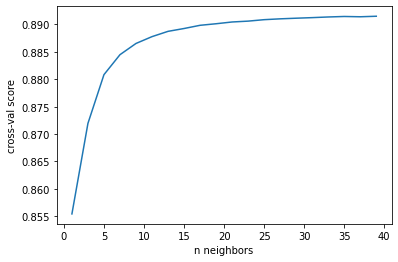

In [ ]:
import matplotlib.pyplot as plt

# plotting the points 
plt.plot(k_num, scores)
  
# naming the x axis
plt.xlabel('n neighbors')
# naming the y axis
plt.ylabel('cross-val score')
  
# function to show the plot
plt.show()

In [ ]:
import time

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors=39)
clf.fit(dataTraining1d,np.ravel(trainGT1d))
end_time = time.time() - start_time
print("training time for knn: %f" % end_time)

training time for knn: 1.478921


In [ ]:
start_time = time.time()
predictions = clf.predict(dataTest1d)
end_time = time.time() - start_time
print("prediction time for knn: %d" % (end_time))

prediction time for knn: 292


In [5]:
clf = KNeighborsClassifier(n_neighbors=39)
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)

# **bayes**

In [ ]:
model = GaussianNB()
scores = cross_val_score(model, dataTraining1d, np.ravel(trainGT1d), cv=5)
acc = scores.mean()
print(acc)

0.8372542024084673


In [ ]:
model = GaussianNB()

start_time = time.time()
model.fit(dataTraining1d, np.ravel(trainGT1d))
end_time = time.time() - start_time
print("training time for bayes: %f" % end_time)

training time for bayes: 0.412065


In [ ]:
start_time = time.time()
predictions = model.predict(dataTest1d)
end_time = time.time() - start_time
print("prediction time for bayes: %f" % (end_time))

prediction time for bayes: 3.674614


In [10]:
clf = GaussianNB()
clf.fit(train_features, train_labels)
predictions_b = clf.predict(test_features)

# **random forest**

In [ ]:
clf = RandomForestClassifier(criterion="gini",
                             max_depth=8,
                             min_samples_split=10,
                             random_state=5)

In [ ]:
scores = cross_val_score(clf, dataTraining1d, np.ravel(trainGT1d), cv=5)
acc = scores.mean()
print(acc)

0.8901494821640012


In [ ]:
clf = RandomForestClassifier(criterion="gini",
                             max_depth=8,
                             min_samples_split=10,
                             random_state=5)

start_time = time.time()
clf.fit(dataTraining1d, np.ravel(trainGT1d))
end_time = time.time() - start_time
print("training time for random forest: %f" % end_time)

training time for random forest: 143.500179


In [ ]:
start_time = time.time()
predictions = clf.predict(dataTest1d)
end_time = time.time() - start_time
print("prediction time for random forest: %f" % (end_time))

prediction time for random forest: 47.698950


In [13]:
clf = RandomForestClassifier(criterion="gini",
                             max_depth=8,
                             min_samples_split=10,
                             random_state=5)

clf.fit(train_features, train_labels)
predictions_rf = clf.predict(test_features)

# **conf matrices**

                        precision    recall  f1-score   support

            Tree cover       0.77      0.69      0.73       445
             Shrubland       0.77      0.61      0.68     17484
             Grassland       0.60      0.56      0.57      4633
              Cropland       0.68      0.78      0.73     32428
              Built-up       0.46      0.10      0.16      1301
Bare/sparse vegetation       0.79      0.88      0.83     42684
          Snow and ice       0.64      0.26      0.37      4602
Permanent water bodies       0.99      0.99      0.99    186016
    Herbaceous wetland       0.27      0.12      0.17       509

              accuracy                           0.90    290102
             macro avg       0.66      0.55      0.58    290102
          weighted avg       0.90      0.90      0.90    290102



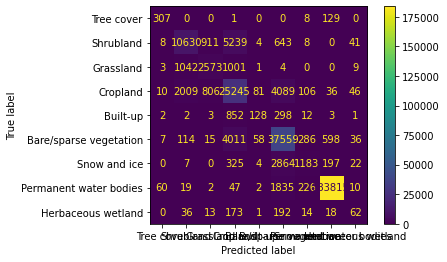

In [8]:
# Compute the confusion matrix - knn
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions)
print(classification_report(test_labels, predictions,target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

            Tree cover       0.41      0.69      0.52       445
             Shrubland       0.41      0.39      0.40     17484
             Grassland       0.26      0.86      0.40      4633
              Cropland       0.60      0.51      0.55     32428
              Built-up       0.00      0.00      0.00      1301
Bare/sparse vegetation       0.75      0.79      0.77     42684
          Snow and ice       0.00      0.00      0.00      4602
Permanent water bodies       0.99      0.98      0.98    186016
    Herbaceous wetland       0.00      0.00      0.00       509

              accuracy                           0.84    290102
             macro avg       0.38      0.47      0.40    290102
          weighted avg       0.84      0.84      0.84    290102



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


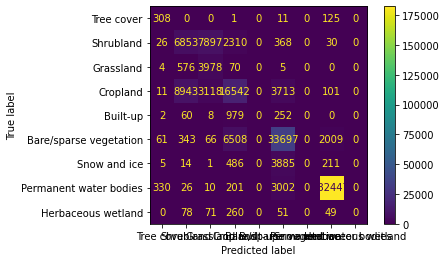

In [11]:
# Compute the confusion matrix - bayes
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions_b)
print(classification_report(test_labels, predictions_b,target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

            Tree cover       0.77      0.69      0.73       445
             Shrubland       0.74      0.60      0.66     17484
             Grassland       0.60      0.40      0.48      4633
              Cropland       0.68      0.77      0.72     32428
              Built-up       0.00      0.00      0.00      1301
Bare/sparse vegetation       0.77      0.90      0.83     42684
          Snow and ice       0.70      0.17      0.27      4602
Permanent water bodies       0.99      0.99      0.99    186016
    Herbaceous wetland       0.00      0.00      0.00       509

              accuracy                           0.90    290102
             macro avg       0.58      0.50      0.52    290102
          weighted avg       0.89      0.90      0.89    290102



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


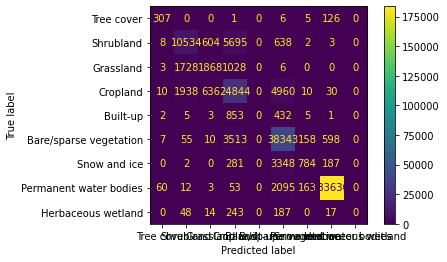

In [14]:
# Compute the confusion matrix - random forest
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions_rf)
print(classification_report(test_labels, predictions_rf,target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()